In [5]:
import sys
import subprocess
import pkg_resources

required = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'plotly', 'country_converter', 'joblib'
]

# install missing packages
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = [pkg for pkg in required if pkg not in installed]
if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])

# now import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
import plotly.express as px
import country_converter as coco
import joblib

sns.set(style='whitegrid')



/tmp/ipython-input-2523270541.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Installing missing packages: ['country_converter']


In [7]:
DATA_PATH = '/content/YouthUnemploy.csv'
print('Loading data from', DATA_PATH)
df = pd.read_csv(DATA_PATH)

# quick peek
print('\nShape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nFirst rows:')
print(df.head())

Loading data from /content/YouthUnemploy.csv

Shape: (181, 3)

Columns: ['Rank', 'Country', 'Unemployement']

First rows:
   Rank           Country  Unemployement
0     1  French Polynesia           56.7
1     2            Kosovo           55.4
2     3      South Africa           53.4
3     4             Libya           48.7
4     5          Eswatini           47.1


In [8]:
orig_cols = df.columns.tolist()
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
print('\nRenamed cols:', df.columns.tolist())

# Rename obvious typos
if 'unemployement' in df.columns:
    df = df.rename(columns={'unemployement': 'unemployment'})

# Ensure unemployment is numeric
df['unemployment'] = pd.to_numeric(df['unemployment'], errors='coerce')
# Drop rows where country or unemployment missing
df = df.dropna(subset=['country', 'unemployment']).reset_index(drop=True)

# If rank exists, ensure integer
if 'rank' in df.columns:
    df['rank'] = pd.to_numeric(df['rank'], errors='coerce').astype('Int64')

print('\nAfter clean shape:', df.shape)

# Basic stats
print(df['unemployment'].describe())



Renamed cols: ['rank', 'country', 'unemployement']

After clean shape: (181, 3)
count    181.000000
mean      18.151381
std       12.233145
min        0.400000
25%        8.700000
50%       14.900000
75%       25.900000
max       56.700000
Name: unemployment, dtype: float64


In [9]:
# country_converter (coco) maps country names to continents with method .convert
cc = coco.CountryConverter()
# Some country names in dataset may not be perfectly standard; we try best-effort

def map_country_to_continent(name):
    try:
        cont = cc.convert(names=name, to='continent')
        # cc returns 'not found' sometimes
        if isinstance(cont, (list, np.ndarray)):
            cont = cont[0]
        if cont in ['not found', None, 'nan']:
            return 'Unknown'
        return cont
    except Exception:
        return 'Unknown'

# apply mapping
print('\nMapping countries to continents (this may take a few seconds)')

df['continent'] = df['country'].apply(map_country_to_continent)

# Clean up continent naming
# Standardize continents (e.g., "Asia" "Europe" ...)
valid_continents = set(['Africa','Americas','Asia','Europe','Oceania','Antarctica'])
# country_converter uses 'North America' etc. Convert to canonical where possible
cont_map_manual = {
    'North America': 'Americas',
    'South America': 'Americas',
    'Central America': 'Americas',
}

df['continent'] = df['continent'].replace(cont_map_manual)
# Any unknowns -> 'Other'
df['continent'] = df['continent'].fillna('Other')
df.loc[~df['continent'].isin(valid_continents), 'continent'] = 'Other'

print('\nContinent distribution:')
print(df['continent'].value_counts())


Mapping countries to continents (this may take a few seconds)

Continent distribution:
continent
Africa     45
Asia       45
Europe     43
Other      33
Oceania    15
Name: count, dtype: int64


In [11]:
# 4.1 Create unemployment_category using quantiles (Low / Medium / High)
quantiles = df['unemployment'].quantile([0.33, 0.66]).values
low_th, high_th = quantiles[0], quantiles[1]

def cat_from_unemp(x):
    if x <= low_th:
        return 'Low'
    elif x <= high_th:
        return 'Medium'
    else:
        return 'High'

df['unemp_category'] = df['unemployment'].apply(cat_from_unemp)

# 4.2 log transform of unemployment to handle skew (add small epsilon)
df['unemp_log'] = np.log1p(df['unemployment'])

# 4.3 create rank_normalized if rank exists
if 'rank' in df.columns:
    df['rank_normalized'] = (df['rank'] - df['rank'].min()) / (df['rank'].max() - df['rank'].min())
else:
    df['rank_normalized'] = np.nan

# 4.4 continent one-hot encoding for modeling
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cont_encoded = encoder.fit_transform(df[['continent']])
cont_cols = [f"continent_{c}" for c in encoder.categories_[0]]
cont_df = pd.DataFrame(cont_encoded, columns=cont_cols, index=df.index)

df = pd.concat([df, cont_df], axis=1)

print('\nSample rows after feature engineering:')
print(df.head())


Sample rows after feature engineering:
   rank           country  unemployment continent unemp_category  unemp_log  \
0     1  French Polynesia          56.7   Oceania           High   4.055257   
1     2            Kosovo          55.4    Europe           High   4.032469   
2     3      South Africa          53.4    Africa           High   3.996364   
3     4             Libya          48.7    Africa           High   3.906005   
4     5          Eswatini          47.1    Africa           High   3.873282   

   rank_normalized  continent_Africa  continent_Asia  continent_Europe  \
0              0.0               0.0             0.0               0.0   
1         0.005556               0.0             0.0               1.0   
2         0.011111               1.0             0.0               0.0   
3         0.016667               1.0             0.0               0.0   
4         0.022222               1.0             0.0               0.0   

   continent_Oceania  continent_Other  


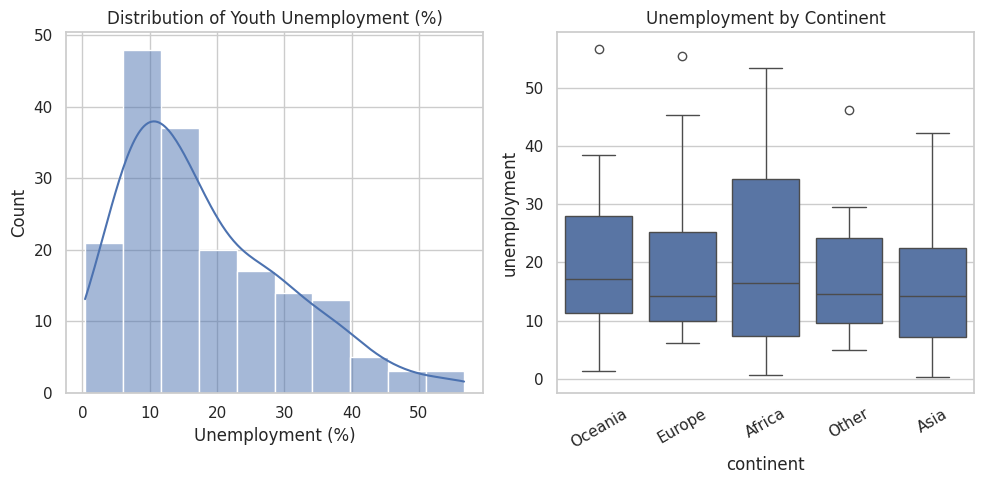

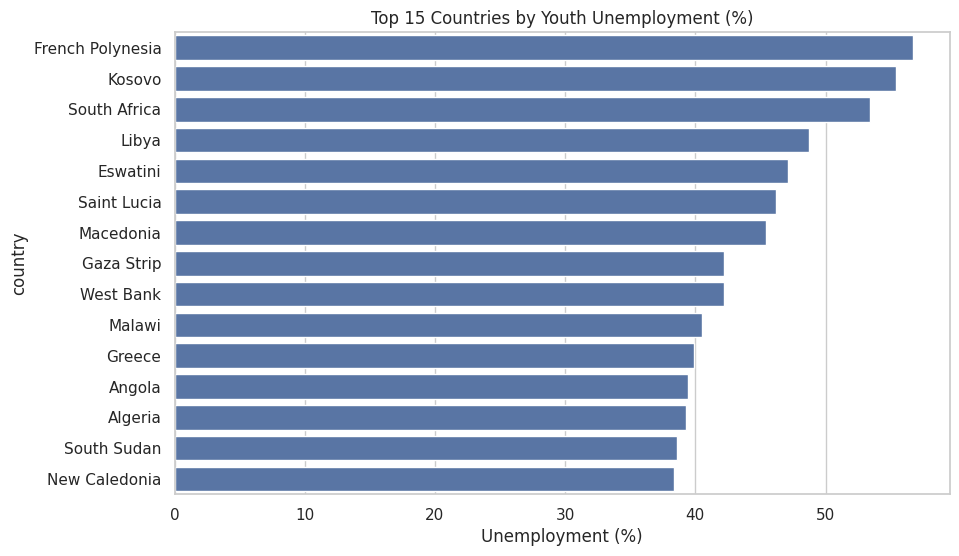

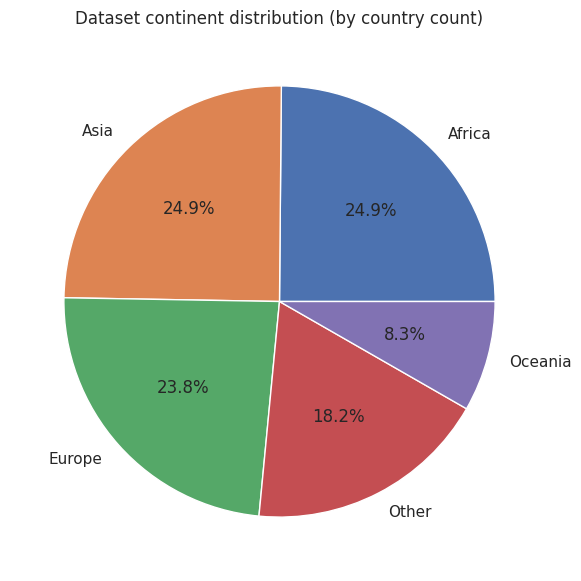

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['unemployment'], kde=True)
plt.title('Distribution of Youth Unemployment (%)')
plt.xlabel('Unemployment (%)')


# 5.2 Boxplot by continent
plt.subplot(1,2,2)
sns.boxplot(x='continent', y='unemployment', data=df)
plt.title('Unemployment by Continent')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# 5.3 Top 15 countries by unemployment
plt.figure(figsize=(10,6))
top15 = df.sort_values('unemployment', ascending=False).head(15)
sns.barplot(y='country', x='unemployment', data=top15)
plt.title('Top 15 Countries by Youth Unemployment (%)')
plt.xlabel('Unemployment (%)')
plt.show()


# 5.4 Pie chart continent share (count of countries in dataset)
plt.figure(figsize=(7,7))
df['continent'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Dataset continent distribution (by country count)')
plt.ylabel('')
plt.show()

k=2, silhouette=0.2449
k=3, silhouette=0.3721
k=4, silhouette=0.5012
k=5, silhouette=0.5895
k=6, silhouette=0.5947
Best k by silhouette: 6 (score 0.5947)


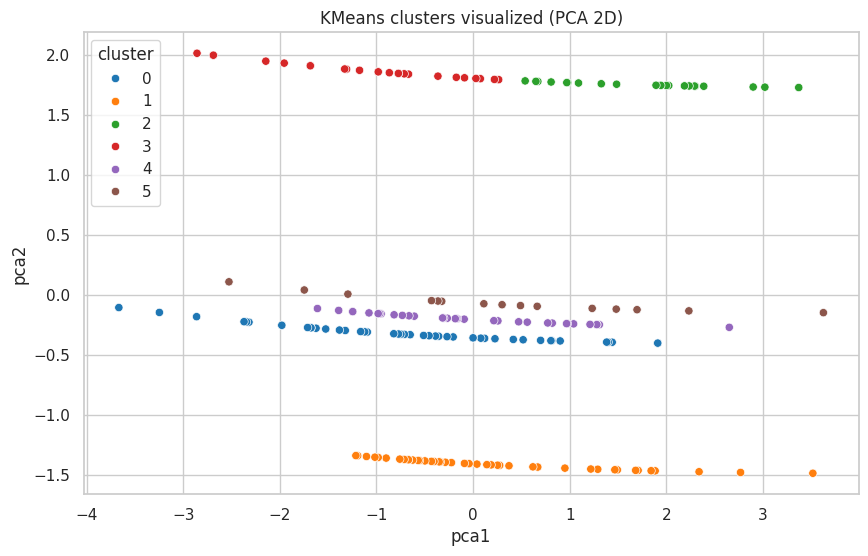


Cluster centers (approx):
   unemployment  unemp_log  continent_Africa  continent_Asia  \
0     16.451111   2.608278     -1.110223e-16    1.000000e+00   
1     18.232558   2.804565     -8.326673e-17   -1.387779e-16   
2     33.319048   3.495376      1.000000e+00    1.110223e-16   
3      8.075000   2.009454      1.000000e+00    1.110223e-16   
4     17.206061   2.775021      2.775558e-17   -5.551115e-17   
5     19.986667   2.767832      1.110223e-16    5.551115e-17   

   continent_Europe  continent_Oceania  continent_Other  
0      1.387779e-16      -4.163336e-17    -5.551115e-17  
1      1.000000e+00      -4.163336e-17    -2.775558e-17  
2     -1.110223e-16      -2.775558e-17     0.000000e+00  
3     -1.110223e-16      -2.775558e-17     2.775558e-17  
4     -5.551115e-17      -4.163336e-17     1.000000e+00  
5     -1.110223e-16       1.000000e+00    -5.551115e-17  

Cluster 0 top countries by unemployment:
         country  unemployment continent
7     Gaza Strip          42.2     

In [17]:
features_for_clust = ['unemployment', 'unemp_log'] + cont_cols
X = df[features_for_clust].fillna(0).values


# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Find best k using silhouette score (k from 2..6)
best_k = 2
best_score = -1
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'k={k}, silhouette={score:.4f}')
if score > best_score:
    best_score = score
    best_k = k


print(f'Best k by silhouette: {best_k} (score {best_score:.4f})')


# Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)


# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:,0]
df['pca2'] = X_pca[:,1]


plt.figure(figsize=(10,6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='tab10')
plt.title('KMeans clusters visualized (PCA 2D)')
plt.show()


# Inspect cluster centers (inverse transform to original space approx)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features_for_clust)
print('\nCluster centers (approx):')
print(centers_df)


# Show top countries in each cluster
for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c} top countries by unemployment:")
    print(df[df['cluster']==c].sort_values('unemployment', ascending=False)[['country','unemployment','continent']].head(8))


In [18]:
iso = IsolationForest(contamination=0.05, random_state=42)
df['outlier_score'] = iso.fit_predict(df[['unemployment']])
# outlier_score == -1 => outlier
outliers = df[df['outlier_score']==-1]
print('\nPotential outlier countries (high unemployment extremes):')
print(outliers[['country','unemployment','continent']].sort_values('unemployment', ascending=False).head(10))


Potential outlier countries (high unemployment extremes):
              country  unemployment continent
0    French Polynesia          56.7   Oceania
1              Kosovo          55.4    Europe
2        South Africa          53.4    Africa
3               Libya          48.7    Africa
4            Eswatini          47.1    Africa
5         Saint Lucia          46.2     Other
6           Macedonia          45.4    Europe
179             Niger           0.7    Africa
180             Qatar           0.4      Asia


In [21]:
clf_df = df.copy()
# If rank missing, use unemployment as fallback feature (but avoid perfect leak)
feature_cols = cont_cols.copy()
if 'rank_normalized' in clf_df.columns and clf_df['rank_normalized'].notna().sum() > 0:
   feature_cols.append('rank_normalized')
else:
# create a synthetic feature: relative_unemployment = unemployment / mean_by_continent
    mean_by_cont = clf_df.groupby('continent')['unemployment'].transform('mean')
    clf_df['rel_unemp'] = clf_df['unemployment'] / (mean_by_cont + 1e-6)
    feature_cols.append('rel_unemp')


Xc = clf_df[feature_cols].fillna(0)
yc = clf_df['unemp_category']


X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)


# Random Forest with GridSearchCV
rfc = RandomForestClassifier(random_state=42)
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 5, 10]
}


grid = GridSearchCV(rfc, param_grid, cv=4, scoring='f1_weighted', n_jobs=-1)
print('\nTraining RandomForest classifier (this may take a little while)...')
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)


best_clf = grid.best_estimator_


# Evaluate
y_pred = best_clf.predict(X_test)
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


# Feature importance
if hasattr(best_clf, 'feature_importances_'):
    imp = pd.Series(best_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print('\nFeature importances:')
    print(imp)


Training RandomForest classifier (this may take a little while)...
Best params: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.92      0.92        13
         Low       1.00      1.00      1.00        12
      Medium       0.92      0.92      0.92        12

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37

Confusion Matrix:
[[12  0  1]
 [ 0 12  0]
 [ 1  0 11]]

Feature importances:
rank_normalized      0.970346
continent_Africa     0.009595
continent_Asia       0.006016
continent_Other      0.005452
continent_Oceania    0.004753
continent_Europe     0.003837
dtype: float64


In [28]:
def map_iso3(name):
    try:
        return cc.convert(names=name, to='ISO3')
    except Exception:
        return None


print('\nMapping ISO3 codes for choropleth...')
df['iso3'] = df['country'].apply(map_iso3)

fig = px.choropleth(
    df,
    locations='iso3',
    color='unemployment',
    hover_name='country',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Youth Unemployment Rate by Country'
)

# Save interactive html
fig.write_html('/content/youth_unemployment_choropleth.html')
print('Saved interactive choropleth to /content/youth_unemployment_choropleth.html')

# If running interactively, show figure
try:
    fig.show()
except Exception:
    pass



Mapping ISO3 codes for choropleth...
Saved interactive choropleth to /content/youth_unemployment_choropleth.html


In [30]:
joblib.dump(kmeans, '/content/kmeans_youth_unemp.joblib')
joblib.dump(scaler, '/content/scaler_youth_unemp.joblib')
joblib.dump(best_clf, '/content/rf_unemp_category.joblib')
print('\nSaved models to /content/')


# Save processed dataframe for easy reuse
df.to_csv('/content/youth_unemployment_processed.csv', index=False)
print('Saved processed dataframe to /content/youth_unemployment_processed.csv')


Saved models to /content/
Saved processed dataframe to /content/youth_unemployment_processed.csv


In [31]:
print('\n=== Quick Insights ===')
print(f"Dataset contains {df.shape[0]} countries.")
print('Top 5 countries by youth unemployment:')
print(df.sort_values('unemployment', ascending=False)[['country','unemployment']].head(5).to_string(index=False))
print('\nContinents with highest median unemployment:')
print(df.groupby('continent')['unemployment'].median().sort_values(ascending=False))
print('\nClusters discovered:')
print(df['cluster'].value_counts())
print('\nPotential extreme outliers (sample):')
print(outliers[['country','unemployment']].head(10).to_string(index=False))


print('\n\nAll artifacts (models, processed CSV, choropleth HTML) have been saved to /mnt/data/.')
print('End of script.')


=== Quick Insights ===
Dataset contains 181 countries.
Top 5 countries by youth unemployment:
         country  unemployment
French Polynesia          56.7
          Kosovo          55.4
    South Africa          53.4
           Libya          48.7
        Eswatini          47.1

Continents with highest median unemployment:
continent
Oceania    17.1
Africa     16.5
Other      14.6
Europe     14.2
Asia       14.2
Name: unemployment, dtype: float64

Clusters discovered:
cluster
0    45
1    43
4    33
3    24
2    21
5    15
Name: count, dtype: int64

Potential extreme outliers (sample):
         country  unemployment
French Polynesia          56.7
          Kosovo          55.4
    South Africa          53.4
           Libya          48.7
        Eswatini          47.1
     Saint Lucia          46.2
       Macedonia          45.4
           Niger           0.7
           Qatar           0.4


All artifacts (models, processed CSV, choropleth HTML) have been saved to /mnt/data/.
End of s